## We want to numerically solve the following ODE with PINN
$$y' + y = 2\pi\cos(2\pi x)+10\pi\cos(10\pi x)+\sin(2\pi x)+\sin(10\pi x),\,\,\,\,\,\,\,\,\,x > 0,$$
## with initial condition
$$y(0)=0$$

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [14]:
scale = 2

In [15]:
def f_source(x, scale):
  return (2*np.pi*np.cos(2*np.pi*x/scale)+10*np.pi*np.cos(10*np.pi*x/scale)+np.sin(2*np.pi*x/scale)+np.sin(10*np.pi*x/scale))

In [16]:
# The true solution for comparison
def true_solution(x, scale):
    return (np.sin(2*np.pi*x/scale)+np.sin(10*np.pi*x/scale))

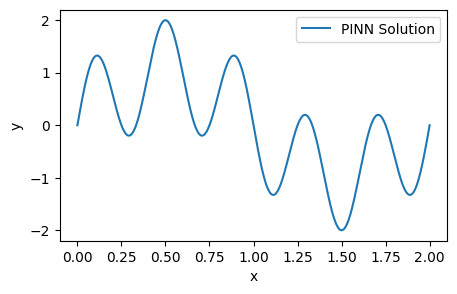

In [17]:
x = np.linspace(0, scale, 500).reshape(-1, 1)
# Plot the results
plt.figure(figsize=(5, 3))
plt.plot(x, true_solution(x, scale=2), label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [18]:
# Define the PINN model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(30, activation='tanh')
        self.hidden_layer_2 = tf.keras.layers.Dense(30, activation='tanh')
        self.hidden_layer_3 = tf.keras.layers.Dense(30, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)
        return self.output_layer(x)

In [19]:
# Define loss function
def compute_loss(model, x, scale):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x)
    dy_dx = tape.gradient(y, x)
    # Physics-informed loss: ODE residual + boundary condition
    residual = scale*dy_dx + y - f_source(x, scale)
    loss_residual = tf.reduce_mean(tf.square(residual))
    # Boundary condition: y(0) = 0
    y0_pred = model(tf.constant([[0.0]]))
    loss_bc = tf.square(y0_pred - 0)
    return   loss_residual + loss_bc

In [20]:
# Training the PINN
def train(model, x_train, epochs, learning_rate, scale):
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, x_train, scale)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.numpy()}')

In [21]:
# Define the training points
x_train = np.linspace(0, scale, 1000).reshape(-1, 1)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)

In [22]:
# Instantiate and train the PINN model
pinn_model = PINN()
train(pinn_model, x_train, epochs=1000, learning_rate=0.001, scale=2)

Epoch: 0, Loss: [[515.8067]]
Epoch: 100, Loss: [[499.31516]]
Epoch: 200, Loss: [[393.9551]]
Epoch: 300, Loss: [[216.50722]]
Epoch: 400, Loss: [[184.61516]]
Epoch: 500, Loss: [[139.45274]]
Epoch: 600, Loss: [[133.94131]]
Epoch: 700, Loss: [[128.64812]]
Epoch: 800, Loss: [[76.85857]]
Epoch: 900, Loss: [[74.845726]]


In [25]:
# Predict with the trained model
x_test = np.linspace(0, scale, 100).reshape(-1, 1)
y_pred = pinn_model(tf.convert_to_tensor(x_test, dtype=tf.float32)).numpy()

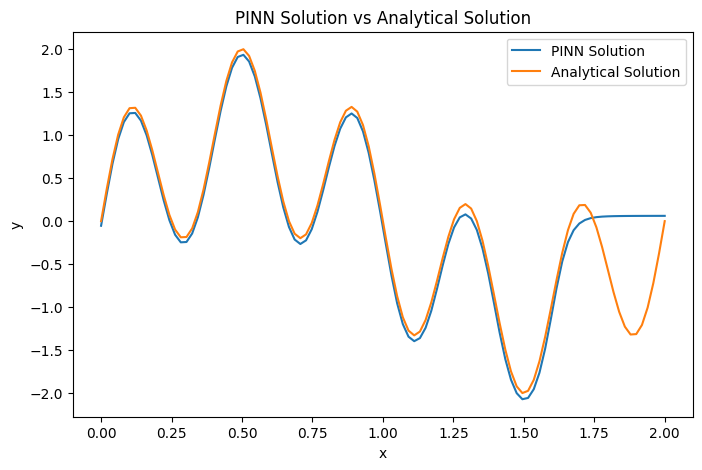

In [26]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x_test, y_pred, label='PINN Solution')
plt.plot(x_test, true_solution(x_test, scale), label='Analytical Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('PINN Solution vs Analytical Solution')
plt.show()